# Project Luther

## 0. Proposal

Build a model that advices studios what to spend their money on when producing a movie by setting up a regression with target Return on investment (=Total Gross/Budget) and the following features:

- Additional Capital (Buget)
- Genre (Action vs. Comedy vs. Drama vs. Animation vs. Documentary)
- 3D technology
- Reputation of Actors (via imbd)
- Reputation of Director (via imbd)
- Reputation of Screenwriter (via imbd)

Then evaluate the effect of each feature towards return on investment.

MVP only includes the first feature answering the question whether it is worthwhile getting more money to increase return on investment.

## 1. Scrap the web

### 1.1 Get Movie data from boxoffice mojo

In [1]:
## **

import numpy as np
import pandas as pd
import requests
from bs4 import BeautifulSoup
import time
import re
import dateutil.parser
import datetime
import statsmodels.api as sm
import statsmodels.formula.api as smf
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.cross_validation import train_test_split
from sklearn.linear_model import RidgeCV
import pickle
import matplotlib.pyplot as plt
from sklearn.externals import joblib
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

from sklearn.linear_model import LinearRegression
from sklearn.cross_validation import train_test_split
from sklearn.linear_model import RidgeCV

import statsmodels.api as sm
import statsmodels.formula.api as smf

from sklearn import preprocessing
from sklearn.cross_validation import train_test_split
from sklearn.decomposition import PCA
from sklearn.feature_selection import f_regression, mutual_info_regression
from sklearn.feature_selection import mutual_info_regression
from sklearn.ensemble import RandomForestRegressor

%matplotlib inline

import sys
reload(sys)
sys.setdefaultencoding('utf-8')

/Users/Nils/anaconda/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
# Adding Headers to Requests (To pretend you are not a bot) **
headers = {'User-Agent':'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_8_5)'}

#### 1.1.1 Get all pages of the worldwide gross numbers

In [35]:
# First get all pages of the worldwide gross numbers starting at #1-#100 and save them to later read the links the movies

page_nums = range(1,100)

for p in page_nums:
    time.sleep(np.random.random())
    url = "http://www.boxofficemojo.com/alltime/domestic.htm?page=%s&p=.htm" %(p)
    resp = requests.get(url, headers=headers)
    if resp.ok:
        soup = BeautifulSoup(resp.text, 'lxml')       
    with open("html/page_nr_%s.html" %(p), 'wb') as f:
        f.write(resp.text)

#### 1.1.2 Go through all pages and save all movies

In [36]:
# For loop to go through pages

movie_list=[]

for p in page_nums:
    soup = BeautifulSoup(open("html/page_nr_%s.html" %(p)).read())

# For loop to go through movies on each page (to come)

    for link in soup.find(id='body').find_all('a'):
        if "movies" in (link['href']):
            time.sleep(np.random.random())
            try:
                cur_mov=(link['href'][(link['href']).index("id=")+3:])
                url = "http://www.boxofficemojo.com/movies/?page=main&id=%s&adjust_yr=2016&p=.htm" %(cur_mov)
                resp = requests.get(url, headers=headers)
                if resp.ok:
                    soup = BeautifulSoup(resp.text, 'lxml')
                with open("html/%sl" %(cur_mov), 'wb') as f:
                    f.write(resp.text)
                movie_list.append(cur_mov)
            except:
                pass

In [37]:
# Save movie_list to pickle file

#with open('html/movie_list.pkl', 'wb') as picklefile:
 #   pickle.dump(movie_list, picklefile)

In [3]:
# **

with open("html/movie_list.pkl", 'rb') as picklefile: 
    movie_list = pickle.load(picklefile)

#### 1.1.3 Read data in from all movies

In [4]:
# Function to get data from movie pages (from lecture)

def get_movie_value(soup, field_name):
    '''Grab a value from boxofficemojo HTML
    
    Takes a string attribute of a movie on the page and
    returns the string in the next sibling object
    (the value for that attribute)
    or None if nothing is found.
    '''
    obj = soup.find(text=re.compile(field_name))
    if not obj: 
        return None
    # this works for most of the values
    next_sibling = obj.findNextSibling()
    if next_sibling:
        return next_sibling.text 
    else:
        return None

In [5]:
# Helper functions to get data from movie pages

def to_date(datestring):
    date = dateutil.parser.parse(datestring)
    return date

def money_to_float(moneystring):
    moneystring = moneystring.replace('$', '').replace(',', '')
    return float(moneystring)

def runtime_to_minutes(runtimestring):
    runtime = runtimestring.split()
    try:
        minutes = int(runtime[0])*60 + int(runtime[2])
        return minutes
    except:
        return None
    
def budget_to_float(budgetstring):
    try:
        budget = float(budgetstring[budgetstring.index("$")+1:budgetstring.index("million")])
        return budget * 1000000
    except:
        return None

In [6]:
# Helper function to include and cluster genre

genre_list = ['Sci-Fi', 'Romance', 'Action', 'Adventure', 'Documentary', 'Animation', 'Comedy', 'Drama', 
              'Fantasy', 'Foreign']


def allocate_genre(genre):
    genre_scifi = 0
    genre_rom = 0
    genre_act = 0
    genre_doc = 0
    genre_anim = 0
    genre_com = 0
    genre_for = 0
    
    if genre_list[0] in genre or genre_list[8] in genre:
        genre_scifi = 1
    if genre_list[1] in genre or genre_list[7] in genre:
        genre_rom = 1
    if genre_list[2] in genre or genre_list[3] in genre:
        genre_act = 1
    if genre_list[4] in genre:
        genre_doc = 1
    if genre_list[5] in genre:
        genre_anim = 1
    if genre_list[6] in genre:
        genre_com = 1
    if genre_list[9] in genre:
        genre_for = 1
        
    return (genre_scifi, genre_rom, genre_act, genre_doc, genre_anim, genre_com, genre_for)

In [7]:
# Helper function to include and cluster rating

def allocate_rating(rating):
    rat_G = 0
    rat_PG = 0
    rat_PG_13 = 0
    rat_R = 0
    rat_NC_17 = 0
    
    if rating == "G":
        rat_G=1
    if rating == "PG":
        rat_PG=1
    if rating == "PG-13":
        rat_PG_13=1
    if rating == "R":
        rat_R=1
    if rating == "NC-17":
        rat_NC_17=1
        
    return (rat_G, rat_PG, rat_PG_13, rat_R, rat_NC_17)

In [8]:
# Helper function to read in actors

def actor_str(list_box_contents):
    actor_str= list_box_contents[2].find_all('tr')[2].find_all('td')[1].find_all('a')[0].text
    for i in xrange(9):
        try:
            actor_str=actor_str + "," + list_box_contents[2].find_all('tr')[2].find_all('td')[1].find_all('a')[i+1].text
        except:
            continue
    return str(actor_str)

In [246]:
# Initiate list for movie data dictionaries

movie_data = []
#movie_list2 = ['startrek11.htm']

# For loop to go through movies

for movie in movie_list:

    soup = BeautifulSoup(open("html/%sl" %(movie)).read())
    
    # Let's get data points again and format them all in one swoop (from lecture)

    # Top table
    
    try:
        title_string = soup.find('title').text
        title = title_string.split('(')[0].strip()
    except:
        title = np.nan

    try:
        raw_release_date = get_movie_value(soup,'Release Date')
        release_date = to_date(raw_release_date)
    except:
        release_date ="N/A"
    
    try:
        raw_runtime = get_movie_value(soup,'Runtime')
        runtime = runtime_to_minutes(raw_runtime)
    except:
        runtime = np.nan
    
    try:
        raw_domestic_total_gross_adj = get_movie_value(soup,'Domestic Total')
        domestic_total_gross_adj = money_to_float(raw_domestic_total_gross_adj)
    except:
        domestic_total_gross_adj = np.nan
    
    try:
        budget_raw = get_movie_value(soup,'Production Budget')
        budget = budget_to_float(budget_raw)
    except:
        budget = np.nan
        
    # rating columns
    
    try:
        rating = get_movie_value(soup,'MPAA Rating')
        rat_G = allocate_rating(rating)[0]
        rat_PG = allocate_rating(rating)[1]
        rat_PG_13 = allocate_rating(rating)[2]
        rat_R = allocate_rating(rating)[3]
        rat_NC_17 = allocate_rating(rating)[4]
    except:
        rating = "N/A"
        rat_G = np.nan
        rat_PG = np.nan
        rat_PG_13 = np.nan
        rat_R = np.nan
        rat_NC_17 = np.nan
    
    # genre columns
    
    try:
        text_genre = get_movie_value(soup,'Genre:')
        genre_tup = allocate_genre(text_genre)
        genre_scifi = genre_tup[0]
        genre_rom = genre_tup[1]
        genre_act = genre_tup[2]
        genre_doc = genre_tup[3]
        genre_anim = genre_tup[4]
        genre_com = genre_tup[5]
        genre_for = genre_tup[6]
    except:
        text_genre = np.nan
        genre_scifi = np.nan
        genre_rom = np.nan
        genre_act = np.nan
        genre_doc = np.nan
        genre_anim = np.nan
        genre_com = np.nan
        genre_for = np.nan
    
    # first content box
    
    try:
        list_box_contents = soup.find_all('div', attrs={'class':'mp_box_content'})
    except:
        list_box_contents = "N/A"
    
    try:
        domestic_total_gross_unadj = float(list_box_contents[0].find_all('td')[1].text.replace('$','').replace(',',''))
    except:
        domestic_total_gross_unadj=np.nan
    
    try:
        foreign_total_gross_unadj = float(list_box_contents[0].find_all('td')[4].text.replace('$','').replace(',',''))
    except:
        foreign_total_gross_unadj = np.nan
    
    # third content box (people)
    
    try:
        director = list_box_contents[2].find_all('td')[1].text
    except:
        director = "N/A"
        
    try:
        actors = actor_str(list_box_contents)
    except:
        actors = "N/A"
        
    
    # fifth content box to check on 3D 
    
    try:
        feat_3d = int("id=3d" in list_box_contents[4].find_all('td')[0].find('a')['href'])
    except:
        feat_3d = 0
        
    
    # add movie to movie_dict
    
    headers_col = ['movie_title', 'domestic_total_gross_adj', 'domestic_total_gross_unadj','foreign_total_gross_unadj', 
                   'budget_unadj', 'Director', 'Actors', 'Rating', '3D', 'Runtime', 'Release_Date',
                   'genre', 'Sci-Fi/ Fantasy', 'Romance/ Drama', 'Action/Adventure', 'Documentary', 
                   'Animation', 'Comedy', 'ForeignLanguage', 'Rating', 'Rat-G', "Rat-PG", "Rat-PG-13", "Rat-R", "Rat-NC-17"]

    movie_dict = dict(zip(headers_col, [title,
                                    domestic_total_gross_adj,
                                    domestic_total_gross_unadj,
                                    foreign_total_gross_unadj,
                                    budget,
                                    director,
                                    actors,
                                    rating,
                                    feat_3d,
                                    runtime,
                                    release_date,
                                    text_genre,
                                    genre_scifi,
                                    genre_rom,
                                    genre_act,
                                    genre_doc,
                                    genre_anim,
                                    genre_com,
                                    genre_for,
                                    rating,
                                    rat_G,
                                    rat_PG,
                                    rat_PG_13,
                                    rat_R,
                                    rat_NC_17]))
    movie_data.append(movie_dict)
    
# put into dataframe

movie_df = pd.DataFrame(movie_data)

In [247]:
def to_int(x):
    try:
        x=int(x)
        return x
    except:
        x=np.nan
        return x    

In [248]:
movie_df["runtime"] = movie_df.Runtime.map(to_int)
movie_df = movie_df.drop("Runtime", axis=1)

In [249]:
# Helper function to determine season

Y=2000
seasons = [('winter', (datetime.datetime(Y,  1,  1),  datetime.datetime(Y,  2, 28))), 
           ('spring', (datetime.datetime(Y,  3, 1),  datetime.datetime(Y,  5, 31))),
           ('summer', (datetime.datetime(Y,  6, 1),  datetime.datetime(Y,  8, 31))),
           ('autumn', (datetime.datetime(Y,  9, 1),  datetime.datetime(Y, 11, 30))),
           ('winter', (datetime.datetime(Y, 12, 1),  datetime.datetime(Y, 12, 31)))]

def get_season(date):
    try:
        date_dum = date.replace(year=Y)
        return next(season for season, (start, end) in seasons if start <= date_dum <= end)
    except:
        return "N/A"

In [250]:
movie_df["Season"] = movie_df.Release_Date.map(get_season)

In [251]:
movie_df["Winter"] = movie_df.Season.map(lambda x : int(x == 'winter'))
movie_df["Spring"] = movie_df.Season.map(lambda x : int(x == 'spring'))
movie_df["Summer"] = movie_df.Season.map(lambda x : int(x == 'summer'))
movie_df["Autumn"] = movie_df.Season.map(lambda x : int(x == 'autumn'))

In [252]:
#Save full movie_df to pickle file

with open('html/full_movie_df.pkl', 'wb') as picklefile:
    pickle.dump(movie_df, picklefile)

In [373]:
with open('html/full_movie_df.pkl', 'rb') as picklefile: 
    movie_df = pickle.load(picklefile)

In [374]:
# Adjust budget and foreign gross for inflation

movie_df["budget_adj"]=movie_df["budget_unadj"]*movie_df["domestic_total_gross_adj"]/movie_df["domestic_total_gross_unadj"]
movie_df["foreign_total_gross_adj"]=movie_df["foreign_total_gross_unadj"]*movie_df["domestic_total_gross_adj"]/movie_df["domestic_total_gross_unadj"]

movie_df["worldwide_total_gross_adj"] = movie_df["foreign_total_gross_adj"] + movie_df["domestic_total_gross_adj"]

In [375]:
# add target variable Return on investments

movie_df["Return_on_investment"] = (movie_df['worldwide_total_gross_adj']-movie_df["budget_adj"])/movie_df["budget_adj"]

In [376]:
#drop unneeded columns

movie_df=movie_df.drop(['budget_unadj', 'domestic_total_gross_unadj', 'foreign_total_gross_unadj', 
                        'foreign_total_gross_adj', 'domestic_total_gross_adj', 'Season'], axis = 1)

In [377]:
#Save movie_df to pickle file

with open('html/movie_df2.pkl', 'wb') as picklefile:
    pickle.dump(movie_df, picklefile)

In [36]:
#with open('html/full_movie_df.pkl', 'rb') as picklefile: 
 #   my_old_movie_df = pickle.load(picklefile)

### 1.2. Get reputation data from imdb

#### 1.2.1. Get Director's reputation from imdb

In [59]:
# Save the list as html

url = "http://www.imdb.com/list/ls008344500/?start=1&view=compact&sort=listorian:asc&scb=0.8729624355591994"

resp = requests.get(url, headers=headers)
if resp.ok:
    soup = BeautifulSoup(resp.text, 'lxml')       
with open("html/directors.html", 'wb') as f:
    f.write(resp.text)

In [79]:
# Get the information out of the list and cluster them in steps of 25 into a dictionary

soup = BeautifulSoup(open("html/directors.html").read())

dir_dict_rep={}

for i in xrange(250):
    dir_name = str(soup.find_all('div', attrs={'class':'list compact'})[0].find_all('tr')[i+1].find_all('td')[1].text)
    dir_rank = int(soup.find_all('div', attrs={'class':'list compact'})[0]
                   .find_all('tr')[i+1].find_all('td')[0].text.replace(".",""))
    dir_cluster = -dir_rank/25+11
    dir_dict_rep[dir_name] = dir_cluster

In [378]:
def cluster_map2(director):
    try:
        sec_name = director[director.index(" "): director.index(" ")+4]
        for key, value in dir_dict_rep.iteritems():
            if sec_name in key:
                return value
            else:
                return 0
    except:
        return 0


In [81]:
# save director dict as pickle file

with open('html/dir_dict.pkl', 'wb') as picklefile:
    pickle.dump(dir_dict_rep, picklefile)

In [379]:
# open director dict from pickle file

with open('html/dir_dict.pkl', 'rb') as picklefile: 
    dir_dict_rep = pickle.load(picklefile)

In [380]:
movie_df["Director_Rep"]=movie_df.Director.map(cluster_map2)

#### 1.2.2 Get Actors reputation from imdb

In [64]:
# Save the list as html

url = "http://www.imdb.com/list/ls000004615/?start=1&view=compact&sort=listorian:asc&scb=0.4331459497671084"

resp = requests.get(url, headers=headers)
if resp.ok:
    soup = BeautifulSoup(resp.text, 'lxml')       
with open("html/actors.html", 'wb') as f:
    f.write(resp.text)

In [65]:
# Get the information out of the list and cluster them in steps of 25 into a dictionary

soup = BeautifulSoup(open("html/actors.html").read())

act_dict_rep={}

for i in xrange(250):
    act_name = str(soup.find_all('div', attrs={'class':'list compact'})[0].find_all('tr')[i+1].find_all('td')[1].text)
    act_rank = int(soup.find_all('div', attrs={'class':'list compact'})[0]
                   .find_all('tr')[i+1].find_all('td')[0].text.replace(".",""))
    act_cluster = -act_rank/25+11
    act_dict_rep[act_name] = act_cluster

In [381]:
def map_act_clust2(act_str):
    act_score=0
    act_list=act_str.split(',')
    try:
        for i in xrange(len(act_list)):
            sec_name = act_list[i][act_list[i].index(" "): act_list[i].index(" ")+4]
            for key, value in act_dict_rep.iteritems():
                if sec_name in key:
                    act_score += value
        return act_score
    except:
        return 0

In [24]:
# save actors dict as pickle file

with open('html/dir_act.pkl', 'wb') as picklefile:
    pickle.dump(act_dict_rep, picklefile)

In [384]:
# open actors dict from pickle file

with open('html/dir_dict.pkl', 'rb') as picklefile: 
    act_dict_rep = pickle.load(picklefile)

In [385]:
movie_df["Actors_Rep"]=movie_df.Actors.map(map_act_clust2)

#### 1.2.3 Get data on based on a book from imdb

In [41]:
# Save the list as html

for i in [1,2,3,4]:
    url = "http://www.goodreads.com/list/show/17956.Best_Movie_Adaptations?page=%s" %(i)
    resp = requests.get(url, headers=headers)
    if resp.ok:
        soup = BeautifulSoup(resp.text, 'lxml')       
    with open("html/adaptions_%s.html" %(i), 'wb') as f:
        f.write(resp.text)

In [51]:
# Set up a dictionary with the movies based on a book

# for loop going through the 4 pages (to come)

adapt_list=[]

for j in [1,2,3,4]:
# get list of books on each page

    soup = BeautifulSoup(open("html/adaptions_%s.html" %(j)).read())

    for i in xrange(99):
        try:
            movie_name = (soup
                      .find_all('table', attrs={'class':'tableList js-dataTooltip'})[0]
                      .find_all('tr')[i].find_all('td')[2].find('span').text
                      )
            adapt_list.append(movie_name)
        except:
            continue

In [52]:
# save adaption list as pickel file

with open('html/adapt.pkl', 'wb') as picklefile:
    pickle.dump(adapt_list, picklefile)

In [386]:
# open adaption list from pickle file

with open('html/adapt.pkl', 'rb') as picklefile: 
    adapt_list1 = pickle.load(picklefile)

In [387]:
def map_adapt(title):
    if any(title[:min(7, len(title))] in s for s in adapt_list):
        return 1
    else:
        return 0

In [388]:
movie_df['Adaption'] = movie_df.movie_title.map(map_adapt)

#### 1.2.4 Get movie on real story

In [362]:
# Get the information out of the list 

true_list =[]

# for loop through two pages

for i in [1,2]:

    soup = BeautifulSoup(open("html/movies_true%s.html" %(i)).read())

    for j in xrange(250):
        try:
            movie_name = str(soup.find_all('div', attrs={'class':'list compact'})[0].find_all('tr')[j+1].find_all('td')[1].text)
            true_list.append(movie_name)
        except:
            continue

In [389]:
def map_true(title):
    if any(title[:min(7, len(title))] in s for s in true_list):
        return 1
    else:
        return 0

In [395]:
movie_df['Based_Real'] = movie_df.movie_title.map(map_true)

In [396]:
#Drop "N/A's"

movie_df=movie_df.dropna(how='any')

In [397]:
#Save movie_df to pickle file

with open('html/movie_df.pkl', 'wb') as picklefile:
    pickle.dump(movie_df, picklefile)

In [3]:
# Open movie df from pickle file **

with open('html/movie_df.pkl', 'rb') as picklefile: 
    movie_df = pickle.load(picklefile)

### 2 Examine the data

#### 2.0 Overall Correlation

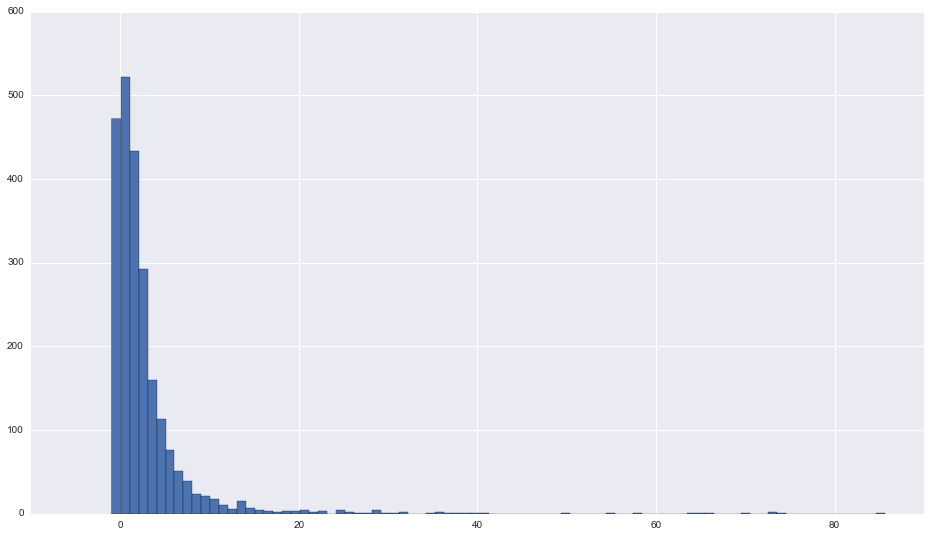

In [149]:
plt.figure(figsize=(16,9))

plt.hist(movie_df['Return_on_investment'], bins = 86);

In [151]:
movie_df.sort_values('Return_on_investment', ascending=False)[['Return_on_investment', 'movie_title']]

,Return_on_investment,movie_title
1360,85.593057,Saw
12,74.515291,E.T.: The Extra-Terrestrial
110,72.748809,My Big Fat Greek Wedding
1678,72.696757,The Full Monty
8,69.490728,Star Wars
89,66.236143,Jaws
188,64.825948,Grease
1408,63.672767,Insidious
785,58.170677,Paranormal Activity 2
1450,54.841098,Four Weddings and a Funeral


In [5]:
# Open the data frame

with open("html/movie_df.pkl", 'rb') as picklefile: 
    movie_df = pickle.load(picklefile)


In [400]:
movie_df.corr()[['Return_on_investment', 'worldwide_total_gross_adj']].sort_values('Return_on_investment', 
                                                                                   ascending=False)

,Return_on_investment,worldwide_total_gross_adj
Return_on_investment,1.000000,0.379666
worldwide_total_gross_adj,0.379666,1.000000
Actors_Rep,0.047645,0.221636
Summer,0.045361,0.129999
Documentary,0.042158,-0.034603
Rat-PG,0.038965,0.135695
Rat-R,0.028524,-0.214755
Adaption,0.020911,0.063524
Rat-G,0.014832,0.082028
3D,0.011891,0.228515


#### 2.1 Genres

In [402]:
movie_df.columns

Index([u'3D', u'Action/Adventure', u'Actors', u'Animation', u'Comedy',
       u'Director', u'Documentary', u'ForeignLanguage', u'Rat-G', u'Rat-NC-17',
       u'Rat-PG', u'Rat-PG-13', u'Rat-R', u'Rating', u'Release_Date',
       u'Romance/ Drama', u'Sci-Fi/ Fantasy', u'genre', u'movie_title',
       u'runtime', u'Winter', u'Spring', u'Summer', u'Autumn', u'budget_adj',
       u'worldwide_total_gross_adj', u'Return_on_investment', u'Director_Rep',
       u'Actors_Rep', u'Adaption', u'Based_Real'],
      dtype='object')

In [404]:
movie_df_genre = movie_df.drop(['3D', 'Rat-G', 'Rat-NC-17', 'Rat-PG', 'Rat-PG-13', 'Winter', 'Spring', 'Summer', 'Autumn',
                                'Rat-R','Rating','genre', 'Director_Rep', 'Actors_Rep', 'Actors', 'Director','Based_Real', 
                                'movie_title', 'budget_adj', 'runtime', 'Adaption' ], axis=1)

In [405]:
movie_df_genre.corr()[['Return_on_investment', 'worldwide_total_gross_adj']].sort_values(['Return_on_investment'], 
                                                                                         ascending=False)

,Return_on_investment,worldwide_total_gross_adj
Return_on_investment,1.000000,0.379666
worldwide_total_gross_adj,0.379666,1.000000
Documentary,0.042158,-0.034603
ForeignLanguage,0.009684,-0.058676
Animation,-0.002312,0.167258
Sci-Fi/ Fantasy,-0.011367,0.204591
Comedy,-0.019745,-0.147337
Romance/ Drama,-0.032878,-0.158874
Action/Adventure,-0.067347,0.211310


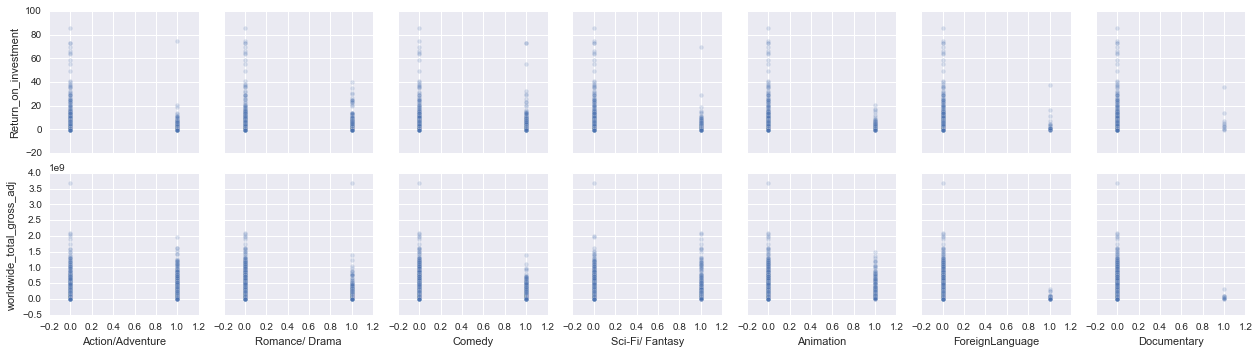

In [406]:
sns.pairplot(movie_df_genre, y_vars=['Return_on_investment', 'worldwide_total_gross_adj'],
             x_vars = ['Action/Adventure', 'Romance/ Drama', 'Comedy',
                       'Sci-Fi/ Fantasy', 'Animation', 'ForeignLanguage','Documentary'], plot_kws={"alpha":0.2})

#### 2.2 Directors and Actors reputation, 3D and Budget, runtime, adaption and based on real

In [407]:
movie_df_rep = movie_df.drop(['movie_title', 'Documentary','Rat-G', 'Rat-NC-17', 'Rat-PG', 'Winter', 'Spring', 
                              'Summer', 'Autumn',
                              'Rat-PG-13','Rat-R','Rating','genre', 'Animation', 'Comedy', 'Action/Adventure',
                              'Romance/ Drama','Sci-Fi/ Fantasy', 'Actors', 'Director', 'ForeignLanguage'], axis = 1)

movie_df_rep.corr()[['Return_on_investment','worldwide_total_gross_adj']].sort_values('Return_on_investment', ascending=False)

,Return_on_investment,worldwide_total_gross_adj
Return_on_investment,1.000000,0.379666
worldwide_total_gross_adj,0.379666,1.000000
Actors_Rep,0.047645,0.221636
Adaption,0.020911,0.063524
3D,0.011891,0.228515
runtime,0.010391,0.317772
Based_Real,0.007998,-0.011921
Director_Rep,-0.011520,-0.016662
budget_adj,-0.136756,0.609788


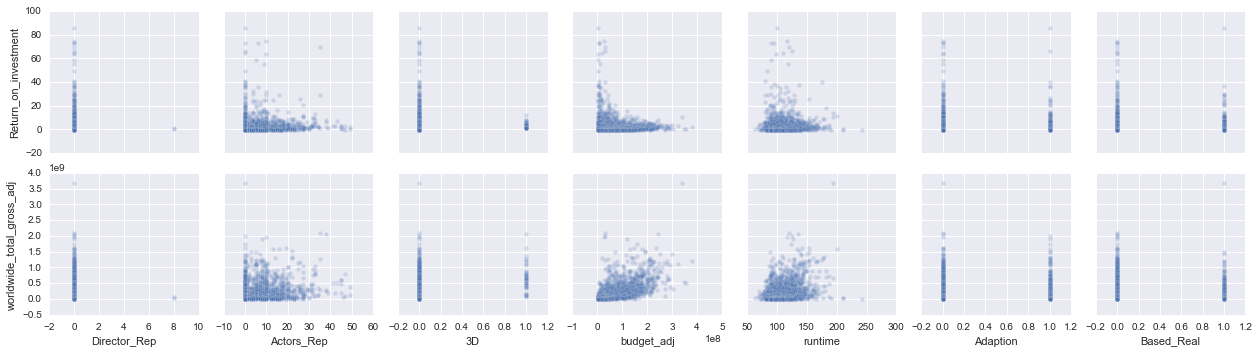

In [408]:
sns.pairplot(movie_df_rep, y_vars=['Return_on_investment', 'worldwide_total_gross_adj'],
             x_vars = ['Director_Rep', 'Actors_Rep', '3D', 'budget_adj', 'runtime', 'Adaption', 'Based_Real'], plot_kws={"alpha":0.2})

#### 2.3 Rating

In [409]:
movie_df_ratings=movie_df.drop(['movie_title', 'budget_adj','Rating','genre', 
                                'Animation', 'Comedy', 'Action/Adventure','Director_Rep', 'Actors_Rep',
                                'Romance/ Drama','Sci-Fi/ Fantasy', 'Actors', 'Adaption', 'Based_Real',
                                'Winter', 'Spring','Summer', 'Autumn',
                                'Director', 'ForeignLanguage', '3D', 'Actors', 'Director','Documentary','runtime'], axis = 1)

movie_df_ratings.corr()[['Return_on_investment', 'worldwide_total_gross_adj']].sort_values('Return_on_investment', ascending=False)

,Return_on_investment,worldwide_total_gross_adj
Return_on_investment,1.000000,0.379666
worldwide_total_gross_adj,0.379666,1.000000
Rat-PG,0.038965,0.135695
Rat-R,0.028524,-0.214755
Rat-G,0.014832,0.082028
Rat-NC-17,-0.002483,-0.025443
Rat-PG-13,-0.063288,0.097081


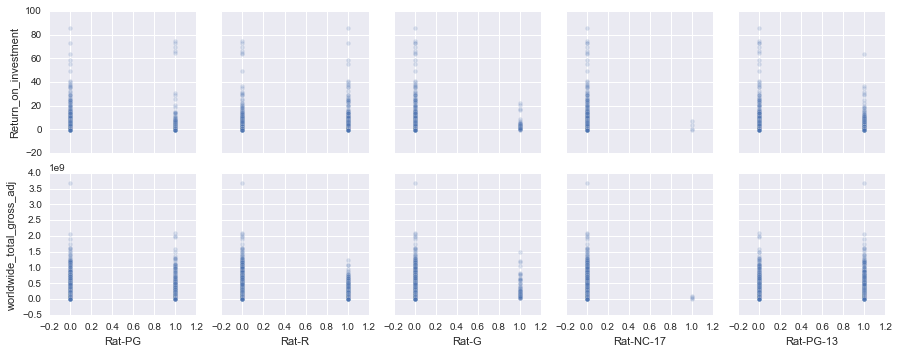

In [410]:
sns.pairplot(movie_df_ratings, y_vars=['Return_on_investment', 'worldwide_total_gross_adj'],
             x_vars = ['Rat-PG', 'Rat-R', 'Rat-G', 'Rat-NC-17', 'Rat-PG-13'], plot_kws={"alpha":0.2})

#### 2.4. Season

In [411]:
movie_df_seasons=movie_df.drop(['movie_title', 'budget_adj','Rating','genre', 
                                'Animation', 'Comedy', 'Action/Adventure','Director_Rep', 'Actors_Rep',
                                'Romance/ Drama','Sci-Fi/ Fantasy', 'Actors', 'Based_Real', 'Adaption',
                                'Rat-G', 'Rat-NC-17', 'Rat-PG', 'Rat-PG-13','Rat-R',
                                'Director', 'ForeignLanguage', '3D', 'Actors', 'Director','Documentary','runtime'], axis = 1)

movie_df_seasons.corr()[['Return_on_investment', 'worldwide_total_gross_adj']].sort_values('Return_on_investment', ascending=False)

,Return_on_investment,worldwide_total_gross_adj
Return_on_investment,1.000000,0.379666
worldwide_total_gross_adj,0.379666,1.000000
Summer,0.045361,0.129999
Autumn,0.007506,-0.101254
Spring,-0.017871,0.035853
Winter,-0.037104,-0.065406


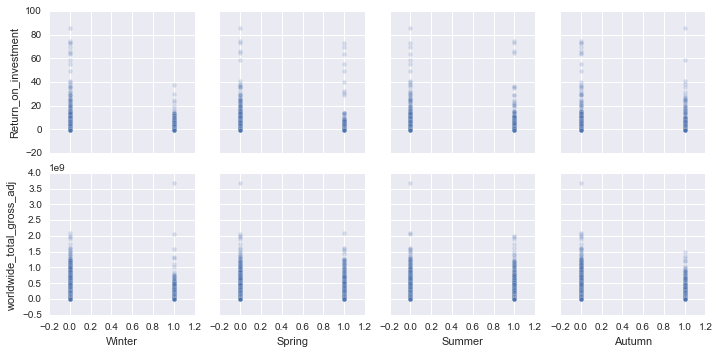

In [412]:
sns.pairplot(movie_df_seasons, y_vars=['Return_on_investment', 'worldwide_total_gross_adj'],
             x_vars = ['Winter', 'Spring', 'Summer','Autumn'], plot_kws={"alpha":0.2})

### 3. Regression model

#### 3.1.1 Linear regression statsmodels without test/train split

In [413]:
Y = movie_df['Return_on_investment']
#Y = movie_df['worldwide_total_gross_adj']
X1 = movie_df['budget_adj']
X21 = movie_df['Action/Adventure']
X22 = movie_df['Animation']
X23 = movie_df['Comedy']
X24 = movie_df['Documentary']
X25 = movie_df['ForeignLanguage']
X26 = movie_df['Romance/ Drama']
X27 = movie_df['Sci-Fi/ Fantasy']
X31 = movie_df['Director_Rep']
X32 = movie_df['Actors_Rep']
X4 = movie_df['3D']
X51 = movie_df['Rat-G']
X52 = movie_df['Rat-NC-17']
X53 = movie_df['Rat-PG']
X54 = movie_df['Rat-PG-13']
X55 = movie_df['Rat-R']
X6 = movie_df['runtime']
X71 = movie_df['Winter']
X72 = movie_df['Spring']
X73 = movie_df['Summer']
X74 = movie_df['Autumn']
X8 = movie_df['Adaption']
X9 = movie_df['Based_Real']


lm1 = smf.ols('Y ~ X1 + X6 + X21 + X22 + X23 + X24 + X25 + X26 + X27 + X31 +X32 + X4 + X51 + X52 + X53 + X54 + X55 + X6 + X71 + X72 + X73 +X74 + X8 + X9', data=movie_df)

fit1 = lm1.fit()
fit1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      Y   R-squared:                       0.055
Model:                            OLS   Adj. R-squared:                  0.045
Method:                 Least Squares   F-statistic:                     5.809
Date:                Wed, 05 Oct 2016   Prob (F-statistic):           5.30e-17
Time:                        22:08:45   Log-Likelihood:                -7481.6
No. Observations:                2322   AIC:                         1.501e+04
Df Residuals:                    2298   BIC:                         1.515e+04
Df Model:                          23                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept     -1.5018      6.404     -0.235      0.815       -14.059    11.056
X1         -2.501e-08   2.94e-09     -8.511      0.000     -3.08e-08 -1.92e-08
X6             0.0370      0.009      4.349      0.000         0.020     0.054
X21           -0.6977      0.365     -1.911      0.056        -1.414     0.018
X22           -0.7512      0.733     -1.024      0.306        -2.189     0.687
X23           -0.9475      0.328     -2.890      0.004        -1.590    -0.305
X24            1.6845      1.871      0.900      0.368        -1.985     5.354
X25           -1.5121      1.257     -1.203      0.229        -3.976     0.952
X26           -1.6876      0.360     -4.689      0.000        -2.393    -0.982
X27           -0.0376      0.463     -0.081      0.935        -0.945     0.870
X31           -0.2063      0.541     -0.381      0.703        -1.267     0.854
X32            0.0649      0.017      3.848      0.000         0.032     0.098
X4             1.4365      0.995      1.444      0.149        -0.515     3.388
X51            2.1156      1.868      1.132      0.258        -1.548     5.780
X52           -0.6542      3.416     -0.191      0.848        -7.354     6.045
X53            1.6274      1.671      0.974      0.330        -1.649     4.904
X54            0.2674      1.642      0.163      0.871        -2.953     3.488
X55            0.2905      1.634      0.178      0.859        -2.913     3.494
X71            1.3621      6.122      0.222      0.824       -10.643    13.368
X72            1.7842      6.124      0.291      0.771       -10.224    13.793
X73            2.7148      6.123      0.443      0.658        -9.293    14.723
X74            1.8264      6.122      0.298      0.765       -10.178    13.831
X8             0.3190      0.349      0.915      0.361        -0.365     1.003
X9             0.0796      0.368      0.216      0.829        -0.643     0.802
==============================================================================
Omnibus:                     2819.902   Durbin-Watson:                   1.765
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           353326.609
Skew:                           6.433   Prob(JB):                         0.00
Kurtosis:                      62.046   Cond. No.                     9.70e+09
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 9.7e+09. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

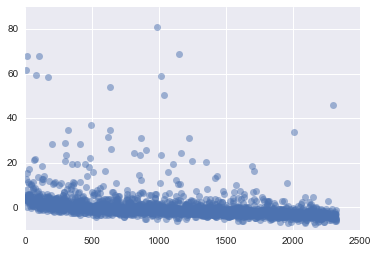

In [414]:
# Plot Residuals
plt.plot(fit1.resid.reset_index().iloc[:,1], 'o', alpha=0.5)
#fit1.resid.plot(style='o', figsize=(12,8), alpha=0.5)

In [415]:
# save model to pickle file

fit1.save('model.pkl')

#### 3.1.2 Linear regression Train / Test split (Sklearn)

In [11]:
#Helper functions for plots

# define error and plot fns
def RMSE(y_test, y_predict):
    RMSE = (sum((y_predict - y_test)**2)/len(y_test))**0.5
    return RMSE

def plot_predict(y_test, y_predict):
    fig, ax = plt.subplots(1, 1, figsize = (10, 5))
    ax.scatter(y_test, y_predict, alpha = 0.25)
    ax.plot(np.linspace(min(y_test), max(y_test), 2), np.linspace(min(y_test), max(y_test), 2), 'r--')
    ax.set_xlabel('y test', fontsize = 20)
    ax.set_ylabel('y predict', fontsize = 20)
    ax.set_xlim([-1,20])
    ax.set_ylim([-1,15])
    #ax.set_aspect("equal")
    ax.set_title(('RMSE = ' + str(RMSE(y_test, y_predict)) + '| R - Squared = ' + str(calc_RSquared(y_test, y_predict))), fontsize = 20)
    ax.tick_params(axis='x', labelsize=20)
    ax.tick_params(axis='y', labelsize=20)
    
def plot_predict_2(y_test, y_predict):
    fig, ax = plt.subplots(1, 1, figsize = (10, 5))
    ax.scatter(y_test, y_predict, alpha = 0.5)
    ax.plot(np.linspace(min(y_test), max(y_test), 2), np.linspace(min(y_test), max(y_test), 2), 'r--')
    ax.set_xlabel('y test', fontsize = 20)
    ax.set_ylabel('y predict', fontsize = 20)
    ax.set_xlim([-1,15])
    ax.set_ylim([-1,15])
    #ax.set_aspect("equal")
    ax.set_title(('RMSE = ' + str(RMSE(y_test, y_predict)) + '| R - Squared = ' + str(calc_RSquared(y_test, y_predict))), fontsize = 20)
    ax.tick_params(axis='x', labelsize=20)
    ax.tick_params(axis='y', labelsize=20)


def calc_RSquared(y_test, y_predict):
    SS_total = np.sum((y_test - np.mean(y_test))**2)
    SS_res = np.sum((y_test - y_predict)**2)
    return (1 - SS_res/SS_total)

In [5]:
movie_df_num = movie_df.drop(['Actors', 'Director','Rating', 'Release_Date','genre','movie_title'], axis=1)

In [418]:
#Save movie_df_num to pickle file

with open('html/movie_df_num.pkl', 'wb') as picklefile:
    pickle.dump(movie_df_num, picklefile)

In [6]:
lr2 = LinearRegression()
X = movie_df_num.drop(['Return_on_investment','worldwide_total_gross_adj'], axis=1)
y = movie_df_num['Return_on_investment']

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
fit2 = lr2.fit(X_train,y_train)
lr2.score(X_test, y_test)

0.041112519222906374

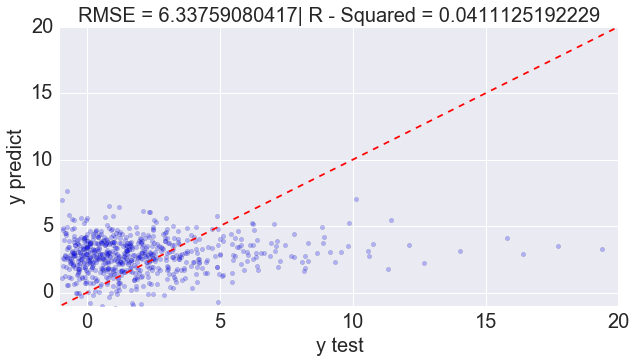

In [74]:
plot_predict(y_test, lr2.predict(X_test))

#### 3.2 Lasso

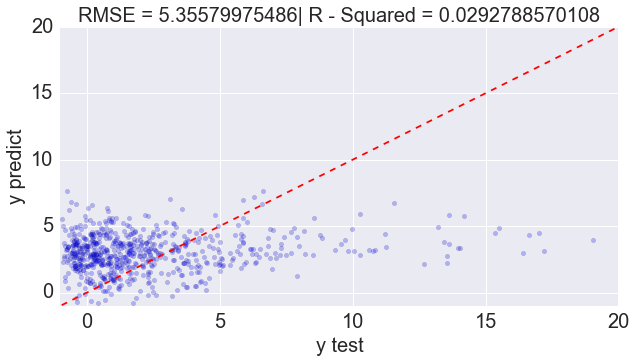

In [75]:
from sklearn.linear_model import Lasso

X1=movie_df.drop(['Actors','genre', 'Director', 'Rating','movie_title','Return_on_investment', 'worldwide_total_gross_adj', 'Release_Date'], axis = 1)
y1 = movie_df['Return_on_investment']
names = X1.columns

X_train_l, X_test_l, y_train_l, y_test_l = train_test_split(X1, y1, test_size=0.3)

lasso_poly = make_pipeline(PolynomialFeatures(1), Lasso(alpha = 0.00001))
lasso_poly.fit(X_train_l, y_train_l)
y_predict = lasso_poly.predict(X_test_l)
plot_predict(y_test_l, y_predict)

#### 3.2. Random Forest

In [20]:
X_rf = movie_df.drop(['Actors','genre', 'Director', 'Rating','movie_title','Return_on_investment', 'worldwide_total_gross_adj', 'Release_Date'], axis = 1)
y_rf = movie_df['Return_on_investment']
names = X_rf.columns

In [67]:
rf = RandomForestRegressor(n_estimators = 50, max_features = 6)
X_train_rf, X_test_rf, y_train_rf, y_test_rf = train_test_split(X_rf, y_rf, test_size=0.25)
fit_rf = rf.fit(X_train_rf, y_train_rf)
fit_rf.score(X_test_rf,y_test_rf)

0.25566395211008008

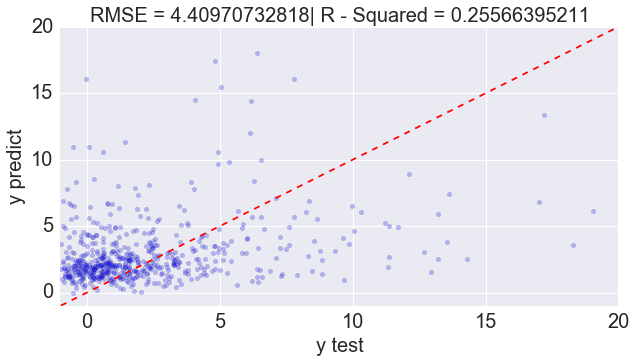

In [76]:
plot_predict(y_test_rf, fit_rf.predict(X_test_rf))

In [489]:
sorted(zip(rf.feature_importances_, names),reverse=True)

[(0.41547592479824808, 'budget_adj'),
 (0.20601780756975405, 'runtime'),
 (0.093361285338586134, 'Actors_Rep'),
 (0.0290525237978136, 'Rat-PG'),
 (0.029044755621631908, 'Comedy'),
 (0.028350980743700686, 'Summer'),
 (0.024789609932246853, 'Based_Real'),
 (0.023432354066047233, 'Romance/ Drama'),
 (0.022680548529965955, 'Autumn'),
 (0.021943541552630261, 'Adaption'),
 (0.020433022272735257, 'Action/Adventure'),
 (0.018514695017665589, 'Spring'),
 (0.016667555876361508, 'Rat-R'),
 (0.011006997617240175, 'Rat-PG-13'),
 (0.0094963739783791631, 'Winter'),
 (0.0081838022113374237, 'Documentary'),
 (0.0053824097916880097, 'Sci-Fi/ Fantasy'),
 (0.0049790794868096247, 'Animation'),
 (0.004363500729799661, 'ForeignLanguage'),
 (0.0043032357629569952, 'Rat-G'),
 (0.0020705158853779786, '3D'),
 (0.00043659750533407845, 'Rat-NC-17'),
 (1.2881913689809785e-05, 'Director_Rep')]

In [491]:
# Pickle fit_rf to a file 
joblib.dump(fit_rf, 'fit_rf.pkl')

# Save X_test and y_test as csv

X_test_rf.to_csv('rf_X_test.csv', index= False)

y_test_rf.to_csv('rf_y_test.csv', index= False)

In [492]:
# save variables to pickle

with open('X_test_rf1.pkl', 'wb') as picklefile:
    pickle.dump(X_test_rf, picklefile)
    
with open('Y_test_rf1.pkl', 'wb') as picklefile:
    pickle.dump(y_test_rf, picklefile)

In [463]:
# load fit_rf from pickle file

fit_rf = joblib.load('fit_rf.pkl')

#open 

X_test_rf = pd.read_csv('rf_X_test.csv')

y_test_rf = pd.read_csv('rf_y_test.csv', header=None)

#### 3.2.2 K-fold testing

In [ ]:
from sklearn.cross_validation import cross_val_score, train_test_split, KFold

kfold = KFold(len(X_train_rf), n_folds=10, shuffle=True)

rf2 = RandomForestRegressor(n_estimators = 50, max_features = 6)

In [ ]:
scores = cross_val_score(rf2, X_rf, y_rf, cv=10, scoring = 'r2')
scores.mean()

#### 3.3.3 Random Forest without large outliers 

In [77]:
movie_df_wo = movie_df[movie_df['Return_on_investment']<20]

In [78]:
X_rf_wo = movie_df_wo.drop(['Actors','genre', 'Director', 'Rating','movie_title','Return_on_investment', 'worldwide_total_gross_adj', 'Release_Date'], axis = 1)
y_rf_wo = movie_df_wo['Return_on_investment']
names = X_rf_wo.columns

In [85]:
rf_wo = RandomForestRegressor(n_estimators = 100, max_features = 6)
X_train_rf_wo, X_test_rf_wo, y_train_rf_wo, y_test_rf_wo = train_test_split(X_rf_wo, y_rf_wo, test_size=0.25)
fit_rf_wo = rf_wo.fit(X_train_rf_wo, y_train_rf_wo)
fit_rf_wo.score(X_test_rf_wo,y_test_rf_wo)

0.11241817602590597

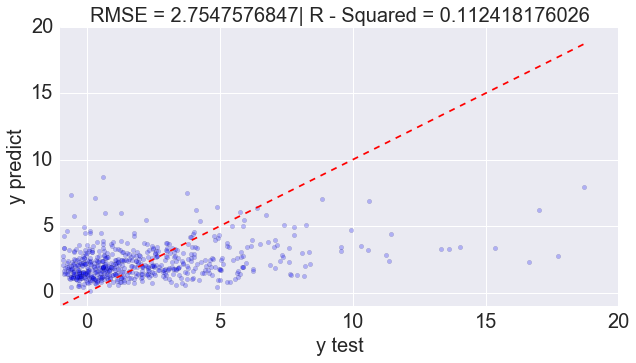

In [86]:
plot_predict(y_test_rf_wo, fit_rf_wo.predict(X_test_rf_wo))£

#### 3.3.4 Random Forrest for profitable movies only

In [87]:
movie_df_nl = movie_df[movie_df['Return_on_investment']>0]

In [88]:
X_rf_nl = movie_df_nl.drop(['Actors','genre', 'Director', 'Rating','movie_title','Return_on_investment', 'worldwide_total_gross_adj', 'Release_Date'], axis = 1)
y_rf_nl = movie_df_nl['Return_on_investment']
names = X_rf_nl.columns

In [112]:
rf_nl = RandomForestRegressor(n_estimators = 100, max_features = 6)
X_train_rf_nl, X_test_rf_nl, y_train_rf_nl, y_test_rf_nl = train_test_split(X_rf_nl, y_rf_nl, test_size=0.25)
fit_rf_nl = rf_wo.fit(X_train_rf_nl, y_train_rf_nl)
fit_rf_nl.score(X_test_rf_nl,y_test_rf_nl)

0.2715224705185405

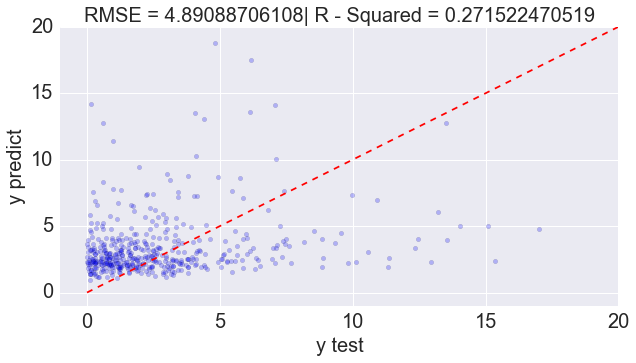

In [113]:
plot_predict(y_test_rf_nl, fit_rf_nl.predict(X_test_rf_nl))

#### 3.3.5 Random Forrest profitable vs. non profitable

In [114]:
def check_prof(RoI):
    if RoI>0:
        return 1
    else:
        return 0

In [115]:
movie_df_prof = movie_df

In [116]:
movie_df_prof['Prof'] = movie_df['Return_on_investment'].map(check_prof)

In [117]:
X_rf_prof = movie_df_prof.drop(['Actors','genre', 'Director', 'Rating','movie_title','Return_on_investment', 'Prof', 'worldwide_total_gross_adj', 'Release_Date'], axis = 1)
y_rf_prof = movie_df_prof['Prof']
names = X_rf_prof.columns

In [121]:
rf_prof = RandomForestRegressor(n_estimators = 50, max_features = 6)
X_train_rf_prof, X_test_rf_prof, y_train_rf_prof, y_test_rf_prof = train_test_split(X_rf_prof, y_rf_prof, test_size=0.25)
fit_rf_prof = rf_wo.fit(X_train_rf_prof, y_train_rf_prof)
fit_rf_prof.score(X_test_rf_prof,y_test_rf_prof)

-0.077580700000000169

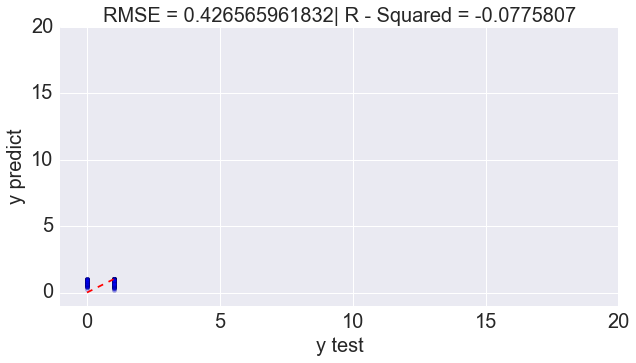

In [122]:
plot_predict(y_test_rf_prof, fit_rf_nl.predict(X_test_rf_prof))

### 4 Selected Genres only

### 4.1 Sci-Fi/ Fantasy Genre

In [12]:
movie_df_act = movie_df[movie_df['Sci-Fi/ Fantasy']==1]

In [13]:
X_rf_act = movie_df_act.drop(['Actors','genre', 'Director', 'Rating','movie_title','Return_on_investment', 'worldwide_total_gross_adj', 'Release_Date',
                         'Sci-Fi/ Fantasy', 'Romance/ Drama', 'Action/Adventure', 'Documentary', 
                              'Animation', 'Comedy', 'ForeignLanguage'], axis = 1)
y_rf_act = movie_df_act['Return_on_investment']
names = X_rf_act.columns

In [33]:
rf_act = RandomForestRegressor(n_estimators = 100, max_features = 6)
X_train_rf_act, X_test_rf_act, y_train_rf_act, y_test_rf_act = train_test_split(X_rf_act, y_rf_act, test_size=0.25)
fit_rf_act = rf_act.fit(X_train_rf_act, y_train_rf_act)
fit_rf_act.score(X_test_rf_act,y_test_rf_act)

0.50777314457514189

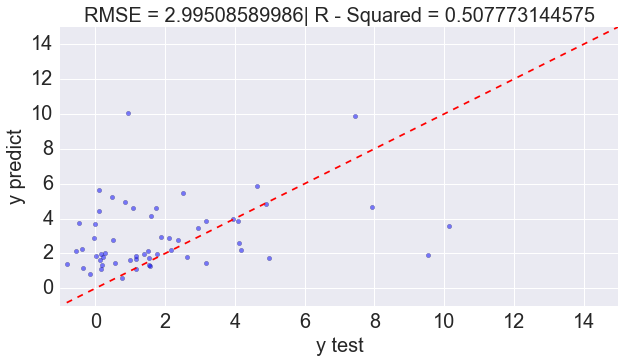

In [34]:
plot_predict_2(y_test_rf_act, fit_rf_act.predict(X_test_rf_act))

In [136]:
X_rf_act.shape

(228, 17)

In [35]:
sorted(zip(rf_act.feature_importances_, names),reverse=True)

[(0.27273251800337778, 'Actors_Rep'),
 (0.26485579677094884, 'budget_adj'),
 (0.23815776339890504, 'runtime'),
 (0.067592390041385175, 'Rat-PG'),
 (0.039650012806072638, 'Spring'),
 (0.030713244171664978, 'Rat-PG-13'),
 (0.026088092432971621, 'Adaption'),
 (0.019831525082657519, 'Summer'),
 (0.011493093506998207, 'Autumn'),
 (0.0085721531163329614, 'Winter'),
 (0.0080387262205344132, 'Based_Real'),
 (0.007550559742223439, 'Rat-R'),
 (0.0047241247059274429, '3D'),
 (0.0, 'Rat-NC-17'),
 (0.0, 'Rat-G'),
 (0.0, 'Director_Rep')]

#### 4.2 Animation

In [36]:
movie_df_rom = movie_df[movie_df['Animation']==1]

In [37]:
X_rf_rom = movie_df_rom.drop(['Actors','genre', 'Director', 'Rating','movie_title','Return_on_investment', 'worldwide_total_gross_adj', 'Release_Date',
                         'Sci-Fi/ Fantasy', 'Romance/ Drama', 'Action/Adventure', 'Documentary', 
                              'Animation', 'Comedy', 'ForeignLanguage'], axis = 1)
y_rf_rom = movie_df_rom['Return_on_investment']
names = X_rf_rom.columns

In [66]:
rf_rom = RandomForestRegressor(n_estimators = 100, max_features = 6)
X_train_rf_rom, X_test_rf_rom, y_train_rf_rom, y_test_rf_rom = train_test_split(X_rf_rom, y_rf_rom, test_size=0.25)
fit_rf_rom = rf_rom.fit(X_train_rf_rom, y_train_rf_rom)
fit_rf_rom.score(X_test_rf_rom,y_test_rf_rom)

0.32700553307024616

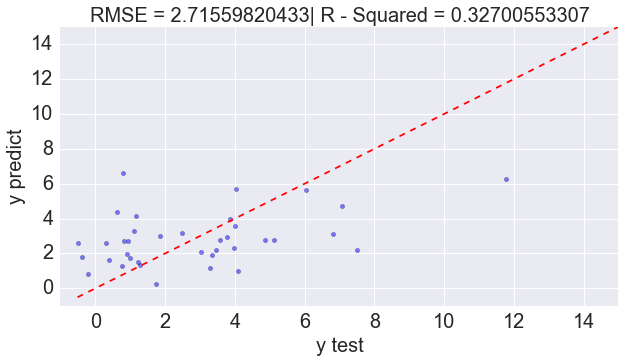

In [67]:
plot_predict_2(y_test_rf_rom, fit_rf_rom.predict(X_test_rf_rom))

In [68]:
X_rf_rom.shape

(149, 16)

In [69]:
sorted(zip(rf_rom.feature_importances_, names),reverse=True)

[(0.24003198644673465, 'budget_adj'),
 (0.23327330483348374, 'Actors_Rep'),
 (0.1585010772586247, 'runtime'),
 (0.099269503801729636, 'Based_Real'),
 (0.063401422714270475, 'Rat-G'),
 (0.058144674248564947, 'Summer'),
 (0.042217653130864043, 'Rat-PG'),
 (0.03049601929704835, 'Adaption'),
 (0.026278170280067875, 'Autumn'),
 (0.024329270858309302, 'Spring'),
 (0.010512332626383371, '3D'),
 (0.0070408000493803321, 'Winter'),
 (0.0049432034808895679, 'Rat-R'),
 (0.001560580973649104, 'Rat-PG-13'),
 (0.0, 'Rat-NC-17'),
 (0.0, 'Director_Rep')]